In [1]:
#Let's import all the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [2]:
#Let's load the dataset as numpy array
path = "C:/Users/sanka/Downloads/Data.csv"
dataset = pd.read_csv(path)
X = normalize(dataset.to_numpy())
print(X.shape)

(1199, 10)


In [3]:
#As per the elbow method, let us set the initial number of clusters in spectral clustering as 9
K = 9
#Let us initialize the variance as 1 for the sake of normalization
sigma = 1

In [10]:
#Let's calculate the similarity matrix using adjacency matrix and use gaussian similarity
def normal_distribution(a, b):
    return np.exp(-1 * (np.linalg.norm(a - b) ** 2)) / (2 * (sigma ** 2))  
# e^-(a-b)^2/2*sigma^2

In [11]:
def adjacency_matrix(X):
    adj_mat = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if(i == j):
                adj_mat[i][j] = 0
            else:
                adj_mat[i][j] = normal_distribution(X[i], X[j])
                
    #Let's consider "K" most similar elements
    for i in range(X.shape[0]):
        idx = np.argsort(-adj_mat[i])
        for j in range(X.shape[0]):
            if(K < idx[j]):
                adj_mat[i][j] = 0
    
    #Let's make adjacency matrix as undirected graph
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            adj_mat[i][j] = max(adj_mat[i][j], adj_mat[j][i])
            
    return adj_mat

In [12]:
adj_matrix = adjacency_matrix(X)

In [13]:
#Now, let us calculate Normalized Laplacian Matrix
def normalized_laplacian(adj_matrix):
    D = np.diag(adj_matrix.sum(axis=1))
    D_inv = np.linalg.inv(D)
    D_inv_sqrt = np.sqrt(D_inv)
    norm_laplacian = np.identity(adj_matrix.shape[0], dtype=float) - np.matmul(D_inv_sqrt, np.matmul(adj_matrix, D_inv_sqrt))
    return norm_laplacian

In [15]:
laplacian = normalized_laplacian(adj_matrix)

In [20]:
#Let us do eigendecomposition of laplacian to obtain eigenvalues and eigenvectors
def plot_eigenvalues(eigenvalues):
    plt.ylabel("EigenValues")
    plt.xlabel("K-Values")
    plt.plot(eigenvalues.tolist(), linestyle="--", marker="o", color="g")
    plt.show()
    
def eigen_decomposition(laplacian):
    eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    #Sort eigenvectors according to their eigenvalues
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)]
    eigenvalues = eigenvalues[np.argsort(eigenvalues)]
    plot_eigenvalues(eigenvalues)
    return eigenvectors, eigenvalues

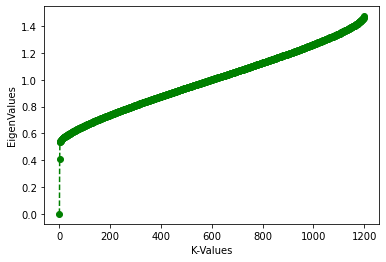

In [21]:
eigenvectors, eigenvalues = eigen_decomposition(laplacian)

In [42]:
#Now, let us perform clustering on reduced eigenspace as follows
def reduced_clustering(eigenvectors, eigenvalues):
    # We count the number of clusters and then find the index of maximum difference in eigenvalues
    num_clusters = -1
    max_diff = 0
    for i in range(len(eigenvalues)-1):
        if(eigenvalues[i+1] - eigenvalues[i] > max_diff):
            num_clusters = i + 1
            max_diff = eigenvalues[i+1] - eigenvalues[i]
    
    #K-means clustering on reduced eigenvector space
    cluster_labels = KMeans(n_clusters=num_clusters + 1).fit(eigenvectors[:,0:num_clusters]).labels_
    
    nsamples_cluster = {}
    for i in cluster_labels:
        if(i not in nsamples_cluster):
            nsamples_cluster[i] = 0
        nsamples_cluster[i] += 1
    
    print("Eigenvalues = ", eigenvalues)
    print("Number of Clusters = ", num_clusters+1)
    print("Cluster Labels = ", cluster_labels)
    print('Number of samples in these ',num_clusters+1,' clusters are:' ,nsamples_cluster)
    return cluster_labels, nsamples_cluster

In [43]:
cluster_labels, nsamples_cluster = reduced_clustering(eigenvectors, eigenvalues)

Eigenvalues =  [-1.90358713e-16  4.07092950e-01  5.34133472e-01 ...  1.46121094e+00
  1.46290043e+00  1.47376993e+00]
Number of Clusters =  2
Cluster Labels =  [0 0 0 ... 0 0 0]
Number of samples in these  2  clusters are: {0: 1057, 1: 142}


In [45]:
#Finally Let us detect outliers
# We find the cluster label containing minimum samples
outlier_cluster = min(nsamples_cluster, key=nsamples_cluster.get)
print("Outlier Cluster = Cluster: ",outlier_cluster)

Outlier Cluster = Cluster:  1


In [47]:
#Add new column to the dataset 
point_type = ["Outlier" if x == outlier_cluster else "Inlier" for x in cluster_labels]
dataset["Point Type"] = point_type
dataset.to_csv("C:/Users/sanka/Downloads/Output.csv")